In [1]:
# Load model from file
import pickle
 
with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

In [7]:
import nltk
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag

nltk.download('omw-1.4')
nltk.download('wordnet') 
nltk.download('wordnet2022')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

lemmatizer = WordNetLemmatizer()
stop_words = list(stopwords.words('english'))

def process_texts(text):

    # Strip and convert text to lower case
    text = text.strip().lower()

    # Remove urls
    text = re.sub(r'http\S+', '', text)
    
    # Remove escape characters
    text = re.sub(r'\@\w+', '', text)

    # Remove emojis
    emoji = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    text = re.sub(emoji, '', text)

    # Remove html tags 
    text = re.sub(r'<.*?>', '', text)
    
    # Remove new line in string form
    text = re.sub(r'\\n', '', text)

    # Replace brackets with space
    text = re.sub(r'[\]\[\)\(]', ' ', text)
    
    # Remove all characters except alphabets
    text = re.sub(r'[^A-Za-z]' ,' ', text)

    # Replace multiple whitespace with single space
    text = re.sub(r'\s\s+', ' ', text)

    # Tokenize the sentence
    tokens = word_tokenize(text)

    # Remove stop words
    tokens = [t for t in tokens if not t in stop_words]

    # POS tag the words
    pos = pos_tag(tokens)

    # Lemmatize all words
    text = []
    for word, tag in pos:
        wntag = tag[0].lower()
        wntag = wntag if wntag in ['a', 'r', 'n', 'v'] else None
        text.append(lemmatizer.lemmatize(word, wntag) if wntag else word)

    # Remove single letter words
    for w in text:
        if len(w) <= 1:
            text.remove(w)

    return ' '.join(text)

[nltk_data] Downloading package omw-1.4 to /home/brian/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /home/brian/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet2022 to
[nltk_data]     /home/brian/nltk_data...
[nltk_data]   Package wordnet2022 is already up-to-date!
[nltk_data] Downloading package punkt to /home/brian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/brian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/brian/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [38]:
import pandas as pd

def predict_stress(text):
    predicted_label = model.predict([text])[0] 
    return predicted_label

def predict_stress_reddit(df_reddit):
    df_reddit = df_reddit[['selftext', 'created']]
    df_reddit = df_reddit.dropna()

    df_reddit['created'] = df_reddit['created'].astype(int)
    df_reddit['created_time'] = pd.to_datetime(df_reddit['created'], unit='s')

    # Process texts
    df_reddit['processed_text'] = df_reddit['selftext'].apply(lambda x : process_texts(x))

    # Remove posts that are too short
    df_reddit = df_reddit[df_reddit['processed_text'].apply(lambda x: len(x.split()) >= 10)]

    # Predict stress
    df_reddit['stress'] = df_reddit['processed_text'].apply(lambda x : predict_stress(x))

    return df_reddit

def predict_stress_reddit_comments(df_reddit):
    df_reddit = df_reddit[['body', 'created']]
    df_reddit = df_reddit.dropna()

    df_reddit['created'] = df_reddit['created'].astype(int)
    df_reddit['created_time'] = pd.to_datetime(df_reddit['created'], unit='s')

    # Process texts
    df_reddit['processed_text'] = df_reddit['body'].apply(lambda x : process_texts(x))

    # Remove posts that are too short
    df_reddit = df_reddit[df_reddit['processed_text'].apply(lambda x: len(x.split()) >= 10)]

    # Predict stress
    df_reddit['stress'] = df_reddit['processed_text'].apply(lambda x : predict_stress(x))

    return df_reddit

In [35]:
df_unimelb_c = pd.read_json('datasets/reddit/unimelb_comments.zip', lines=True)

In [42]:
df_unimelb_c['created']

0                  NaN
1                  NaN
2                  NaN
3                  NaN
4                  NaN
              ...     
205300    1.704054e+09
205301    1.704058e+09
205302    1.704060e+09
205303    1.704061e+09
205304    1.704065e+09
Name: created, Length: 205305, dtype: float64

In [112]:
df_unimelb = predict_stress_reddit(pd.read_json('datasets/reddit/unimelb_submissions.zip', lines=True))
#df_unimelb = predict_stress_reddit_comments(pd.read_json('datasets/reddit/unsw_comments.zip', lines=True))
#df_sfu.sample(10)

In [90]:
df_unimelb.sample(10)

,selftext,created,created_time,processed_text,stress
20338,"Hey, to the directors/execs of all sorts of so...",1680661489,2023-04-05 02:24:49,hey director execs sort society merch etc orde...,0
24920,Hey guys! I’ve messed up my holiday plans and ...,1702807316,2023-12-17 10:01:56,hey guy mess holiday plan book wrong flight ti...,0
21215,I've just heard about ACS in bachelor of comp ...,1685034528,2023-05-25 17:08:48,heard acs bachelor comp sci accreditation much...,0
23250,Hello! \n\nI need some advise on housing at UN...,1695618048,2023-09-25 05:00:48,hello need advise housing unsw international s...,0
22161,"Hi everyone, I'm very interested in looking fo...",1690618319,2023-07-29 08:11:59,hi everyone interested look plt australia come...,0
21373,"Just got myself enrolled in comp9417, when I t...",1685699037,2023-06-02 09:43:57,get enrol comp try google resource saw ad post...,0
23819,Psychology Honours supervisor recommendations?...,1698627834,2023-10-30 01:03:54,psychology honour supervisor recommendation an...,0
24761,bro i was fully prepared to see a fail for com...,1702500575,2023-12-13 20:49:35,bro fully prepared see fail comp depress last ...,1
478,Basically my course requires 12 units of gen e...,1416289711,2014-11-18 05:48:31,basically course require unit gen ed unit open...,0
23588,I am a first year comp sci major with a HD wam...,1697365603,2023-10-15 10:26:43,first year comp sci major hd wam however hat c...,0


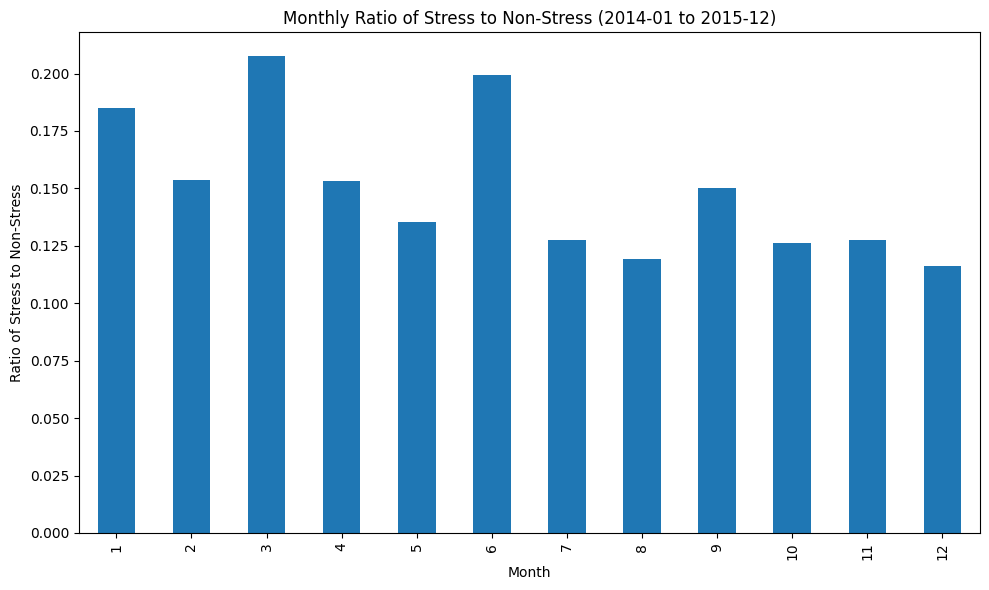

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

start_date = '2014-01-01'
end_date = '2015-12-31'
filtered_df = df_unimelb
#filtered_df = df_sfu[(df_sfu['created_time'] >= start_date) & (df_sfu['created_time'] <= end_date)]

# Group by the month of the 'created' date, then sum the 'stress' values
monthly_data = filtered_df.groupby(filtered_df['created_time'].dt.month).stress.agg(['sum', 'count'])
monthly_data['non_stress'] = monthly_data['count'] - monthly_data['sum']
monthly_data['ratio'] = monthly_data['sum'] / monthly_data['non_stress']

# Reset index to convert PeriodIndex to DateTimeIndex for plotting
#monthly_data.index = monthly_data.index.to_timestamp()

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
monthly_data['ratio'].plot(kind='bar', ax=ax)

# Formatting the x-axis
ax.set_xlabel('Month')
ax.set_ylabel('Ratio of Stress to Non-Stress')
ax.set_title('Monthly Ratio of Stress to Non-Stress (2014-01 to 2015-12)')

# Handling x-ticks - Set major formatter
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Adjust x-ticks to display months within the range
ax.set_xticks(range(len(monthly_data.index)))
#ax.set_xticklabels([date.strftime('%Y-%m') for date in monthly_data.index], rotation=45)

plt.tight_layout()
plt.show()

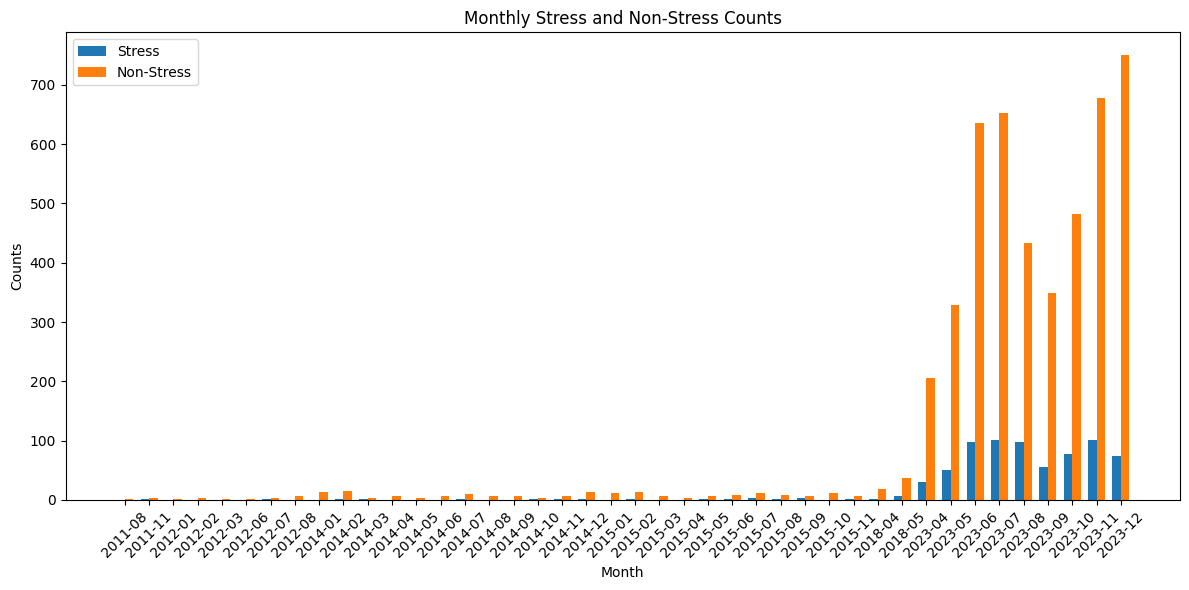

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Group by month
monthly_data = df_unimelb.groupby(df_unimelb['created_time'].dt.to_period('M')).stress.agg(['sum', 'count'])
monthly_data['non_stress'] = monthly_data['count'] - monthly_data['sum']
monthly_data['stress'] = monthly_data['sum']  # Rename for clarity

# Reset index for plotting
monthly_data.index = monthly_data.index.to_timestamp()

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Locations of the groups
ind = range(len(monthly_data))

# Bar width
width = 0.35

# Plotting both stress and non-stress
stress_bars = ax.bar(ind, monthly_data['stress'], width, label='Stress')
non_stress_bars = ax.bar([p + width for p in ind], monthly_data['non_stress'], width, label='Non-Stress')

# Formatting the plot
ax.set_xlabel('Month')
ax.set_ylabel('Counts')
ax.set_title('Monthly Stress and Non-Stress Counts')
ax.set_xticks([p + width / 2 for p in ind])
ax.set_xticklabels([date.strftime('%Y-%m') for date in monthly_data.index], rotation=45)

#ax.set_yscale('log')

ax.legend()

plt.tight_layout()
plt.show()

In [116]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_monthly_stress_ratio(df, ax):
    df['month'] = df['created_time'].dt.month

    # Calculate counts of stressed and not stressed for each month
    monthly_counts = df.groupby('month').stress.value_counts().unstack(fill_value=0)

    # Calculate the ratio of stressed to not stressed
    monthly_counts['ratio'] = monthly_counts[1] / (monthly_counts[0] + monthly_counts[1])

    # Sort by month for plotting
    monthly_counts = monthly_counts.sort_index()

    # Plotting on the provided axes
    monthly_counts['ratio'].plot(kind='bar', color='coral', ax=ax)

    # Formatting the plot
    ax.set_xlabel('Month')
    ax.set_ylabel('Ratio of Stressed')
    ax.set_title('Monthly Ratio of Stressed to Not Stressed')
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
    ax.grid(axis='y')


def plot_weekly_stress_ratio(df, ax):

    df['week'] = df['created_time'].dt.isocalendar().week

    # Calculate counts of stressed and not stressed for each week
    weekly_counts = df.groupby('week').stress.value_counts().unstack(fill_value=0)

    # Calculate the ratio of stressed to not stressed
    weekly_counts['ratio'] = weekly_counts[1] / (weekly_counts[0] + weekly_counts[1])

    # Sort by week for plotting
    weekly_counts = weekly_counts.sort_index()

    # Plotting on the provided axes
    weekly_counts['ratio'].plot(kind='bar', color='coral', ax=ax)

    # Formatting the plot
    ax.set_xlabel('Week Number')
    ax.set_ylabel('Ratio of Stressed')
    ax.set_title('Weekly Ratio of Stressed to Not Stressed')
    
    # Dynamically set x-ticks and labels based on the data
    ax.set_xticks(range(len(weekly_counts.index)))
    ax.set_xticklabels([str(week) for week in weekly_counts.index], rotation=45)
    ax.grid(axis='y')

In [114]:
df_usyd = predict_stress_reddit(pd.read_json('datasets/reddit/usyd_submissions.zip', lines=True))

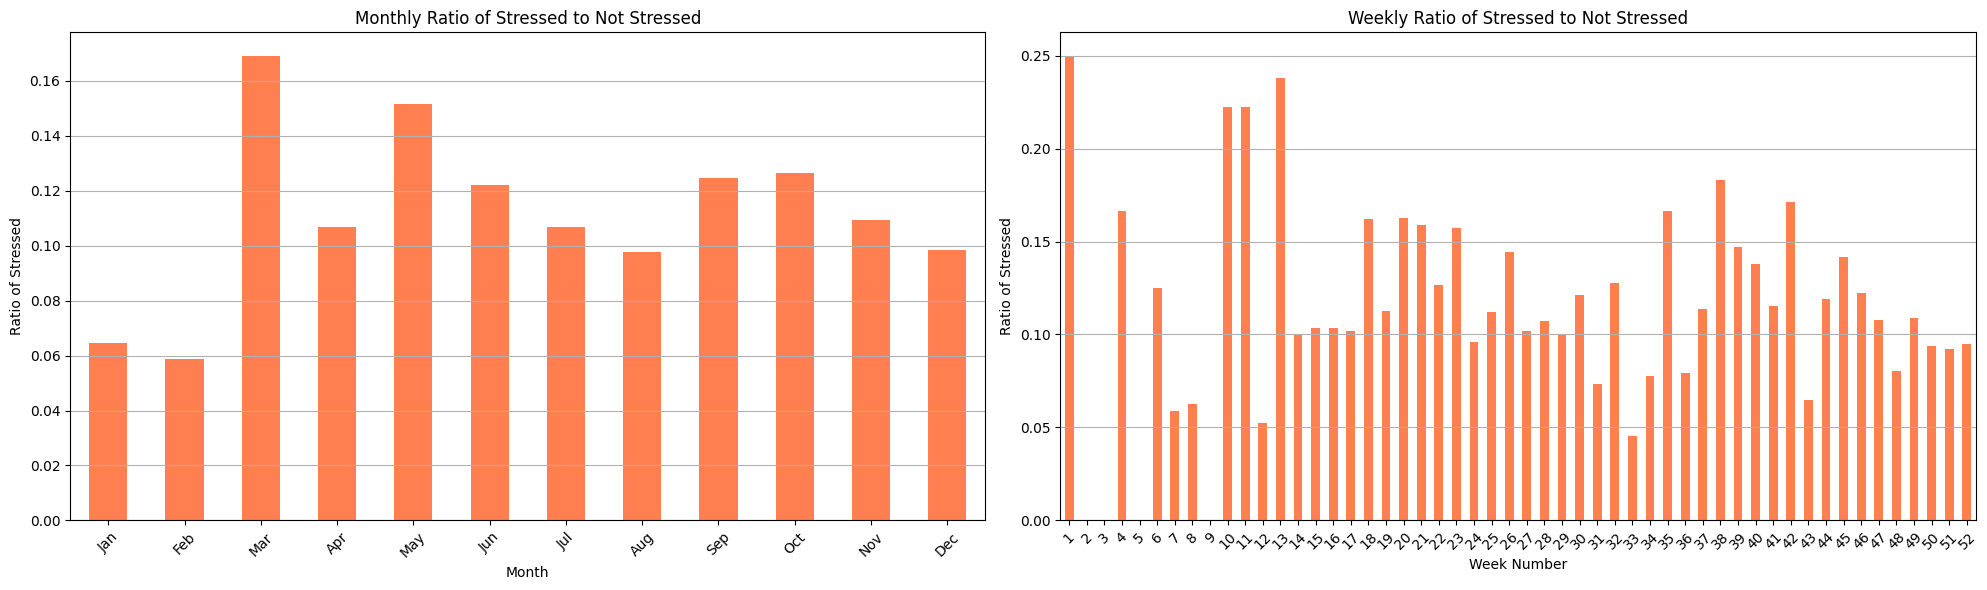

In [117]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))  # 1 row, 2 columns

plot_monthly_stress_ratio(df_usyd, axs[0])
plot_weekly_stress_ratio(df_usyd, axs[1])

plt.tight_layout()
plt.show()


In [110]:
df_sfu = predict_stress_reddit(pd.read_json('datasets/reddit/simonfraser_submissions.zip', lines=True))

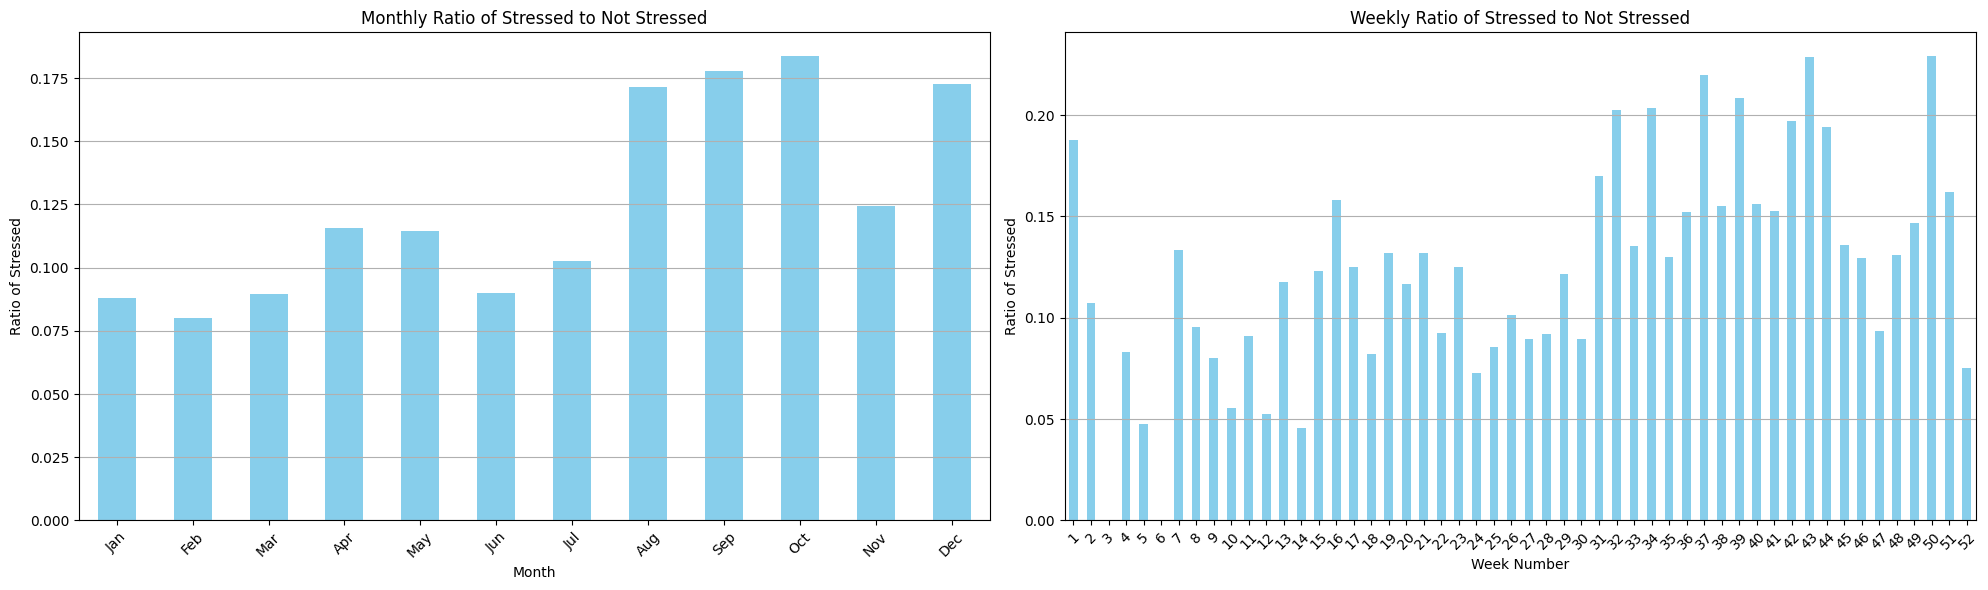

In [111]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))  # 1 row, 2 columns

# Plotting the monthly stress ratio on the first subplot
plot_monthly_stress_ratio(df_sfu, axs[0])

# Plotting the weekly stress ratio on the second subplot
plot_weekly_stress_ratio(df_sfu, axs[1])

plt.tight_layout()
plt.show()

In [122]:
df_uoft = predict_stress_reddit(pd.read_json('datasets/reddit/UofT_submissions.zip', lines=True))

In [124]:
df_ubc = predict_stress_reddit(pd.read_json('datasets/reddit/ubco_submissions.zip', lines=True))

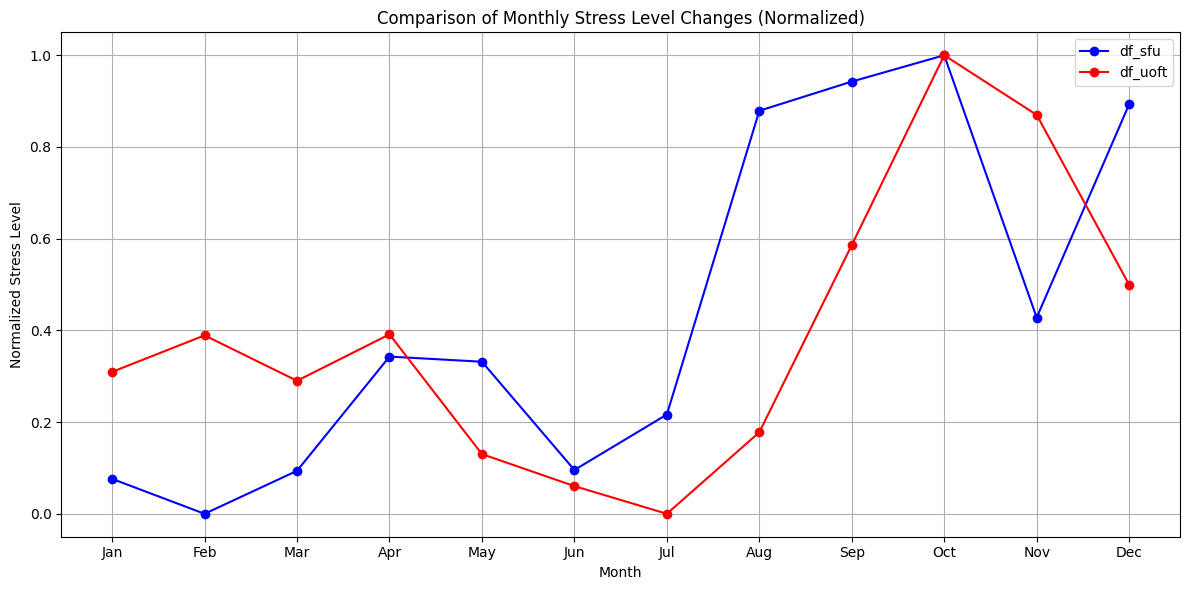

In [126]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def normalize_monthly_stress(df):
    df['month'] = df['created_time'].dt.month

    # Group by the extracted month and calculate the mean stress
    monthly_stress_mean = df.groupby('month')['stress'].mean()

    # Normalize the monthly stress means
    scaler = MinMaxScaler()
    monthly_stress_normalized = scaler.fit_transform(monthly_stress_mean.values.reshape(-1, 1)).flatten()

    return monthly_stress_normalized

def compare_monthly_stress_changes(df1, df2):
    # Normalize monthly stress for both dataframes
    normalized_stress_df1 = normalize_monthly_stress(df1)
    normalized_stress_df2 = normalize_monthly_stress(df2)

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, 13), normalized_stress_df1, marker='o', linestyle='-', color='blue', label='df_sfu')
    plt.plot(range(1, 13), normalized_stress_df2, marker='o', linestyle='-', color='red', label='df_uoft')

    # Formatting the plot
    plt.xlabel('Month')
    plt.ylabel('Normalized Stress Level')
    plt.title('Comparison of Monthly Stress Level Changes (Normalized)')
    plt.xticks(np.arange(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

compare_monthly_stress_changes(df_sfu, df_uoft)


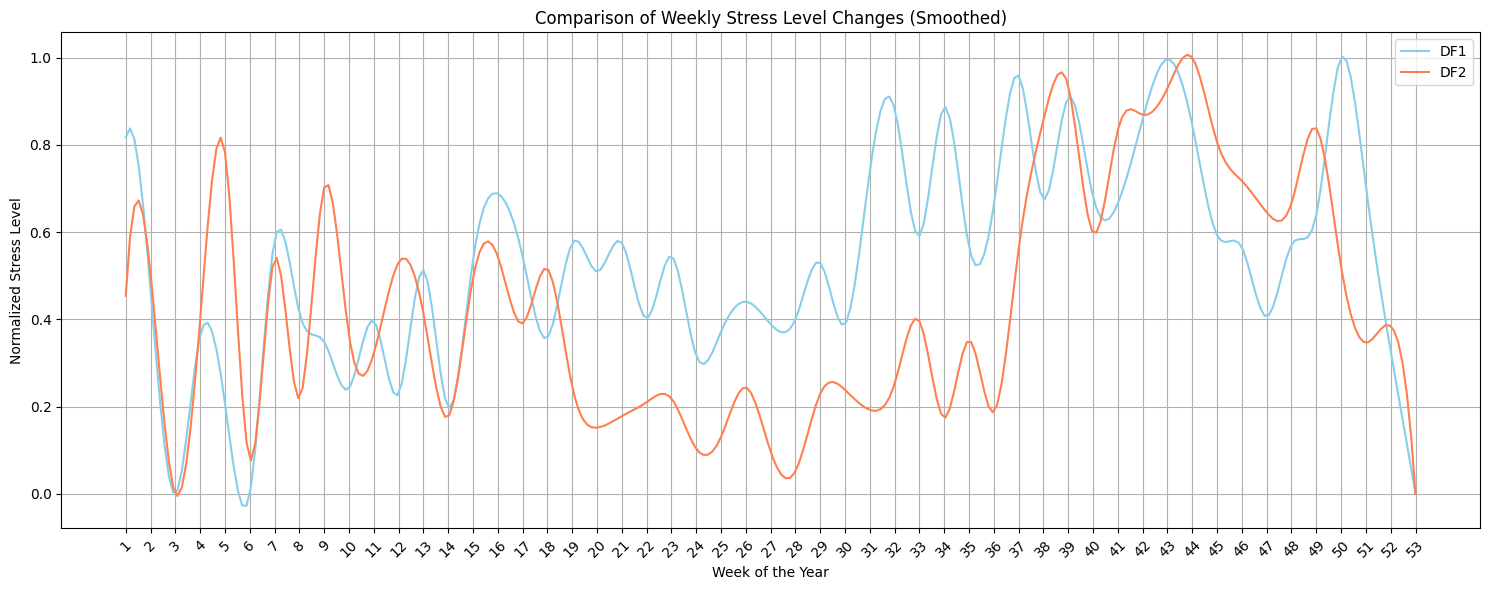

In [131]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import make_interp_spline

def normalize_weekly_stress(df):
    df['week'] = df['created_time'].dt.isocalendar().week
    weekly_stress_mean = df.groupby('week')['stress'].mean()
    scaler = MinMaxScaler()
    weekly_stress_normalized = np.zeros(53)
    normalized_values = scaler.fit_transform(weekly_stress_mean.values.reshape(-1, 1)).flatten()
    weekly_stress_normalized[weekly_stress_mean.index - 1] = normalized_values
    return weekly_stress_normalized

def smooth_plot_weeks(x, y):
    # Generating 300 points for a smoother line
    x_smooth = np.linspace(x.min(), x.max(), 300)
    y_smooth = make_interp_spline(x, y)(x_smooth)
    return x_smooth, y_smooth

def compare_weekly_stress_changes_smooth(df1, df2):
    normalized_stress_df1 = normalize_weekly_stress(df1)
    normalized_stress_df2 = normalize_weekly_stress(df2)

    weeks = np.arange(1, 54)  # Weeks 1 through 53
    
    # Smooth the line
    weeks_smooth_df1, stress_smooth_df1 = smooth_plot_weeks(weeks, normalized_stress_df1)
    weeks_smooth_df2, stress_smooth_df2 = smooth_plot_weeks(weeks, normalized_stress_df2)

    plt.figure(figsize=(15, 6))
    plt.plot(weeks_smooth_df1, stress_smooth_df1, linestyle='-', color='skyblue', label='DF1')
    plt.plot(weeks_smooth_df2, stress_smooth_df2, linestyle='-', color='coral', label='DF2')

    plt.xlabel('Week of the Year')
    plt.ylabel('Normalized Stress Level')
    plt.title('Comparison of Weekly Stress Level Changes (Smoothed)')
    plt.xticks(np.arange(1, 54, step=1), rotation=45)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


compare_weekly_stress_changes_smooth(df_sfu, df_uoft)
